# Granger Causality

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
from collections import defaultdict
import re

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools
from scipy.stats import linregress

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [5]:
from statsmodels.tsa.stattools import grangercausalitytests


## Inputs & Data

Explanation of each input and where it comes from.

In [6]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [7]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [8]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 4, "high_freq": 12}, "beta": {"low_freq": 13, "high_freq": 30}, "gamma": {"low_freq": 30, "high_freq": 70}}

In [9]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
NOTCH_FREQ=60
ORIGINAL_SAMPLE_RATE = 20000
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [10]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 3
TIME_WINDOW_STEP = 1.5 

TRIAL_TIME_STAMP_DURATION = 1000*10

In [11]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s+"}

In [12]:
NUM_LINES = 3

In [13]:
# Generate colors from the "Blues" colormap
LOSING_COLORS = cm.Oranges(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
WINNING_COLORS = cm.Blues(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
REWARDED_COLORS = cm.Greens(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
OMISSION_COLORS = cm.Reds(np.linspace(0.5, 1, NUM_LINES))

In [76]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "orange",
'lose_baseline': LOSING_COLORS[0],
'omission': "red",
'omission_baseline': "hotpink",
'rewarded': "green",
'rewarded_baseline': REWARDED_COLORS[0],
'win': "blue",
'win_baseline': WINNING_COLORS[0],
'lose_comp': "orange", 
'lose_non_comp': "yellow",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [15]:
BASELINE_OUTCOME_TO_COLOR = {'lose_trial': "orange",
 'lose_baseline': LOSING_COLORS[0],
 'omission_trial': "red",
 'omission_baseline': "hotpink",
 'rewarded_trial': "green",
 'rewarded_baseline': REWARDED_COLORS[0],
 'win_trial': "blue",
 'win_baseline': WINNING_COLORS[0]}

In [16]:
COMPETITIVE_OUTCOME_TO_COLOR = {'lose_comp': "orange", 
'lose_non_comp': "yellow",
'omission': "red",
'rewarded': "green",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [17]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [18]:
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [19]:
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [20]:
FULL_LFP_TRACES = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")

In [21]:
FULL_LFP_TRACES = FULL_LFP_TRACES.drop_duplicates(subset=["recording_file", "time"], keep="first")

In [22]:
GROUPINGS = "competition_closeness"


## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

In [23]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [24]:
def nested_dict():
    return defaultdict(dict)

triple_nested_dict = defaultdict(nested_dict)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [25]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

## Granger Causality

In [26]:
baseline_cols = FULL_LFP_TRACES.columns

In [27]:
brain_region_cols = [col for col in FULL_LFP_TRACES.columns if "spike_interface" in col]

In [28]:
brain_region_cols

['spike_interface_mPFC',
 'spike_interface_vHPC',
 'spike_interface_BLA',
 'spike_interface_LH',
 'spike_interface_MD']

In [29]:
baseline_pairs = generate_pairs(sorted([col for col in FULL_LFP_TRACES.columns if "baseline_lfp_trace" in col]))
trial_pairs = generate_pairs(sorted([col for col in FULL_LFP_TRACES.columns if "trial_lfp_trace" in col]))

In [30]:
baseline_pairs

[('BLA_baseline_lfp_trace', 'LH_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'MD_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'MD_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('MD_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('MD_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('mPFC_baseline_lfp_trace', 'vHPC_baseline_lfp_trace')]

In [31]:
def get_granger(row, region_1, region_2, max_lag=3):
    """
    """
    try:
        return grangercausalitytests(np.hstack([row[region_1][np.newaxis].T, row[region_2][np.newaxis].T]), maxlag=[max_lag])[max_lag][0]["ssr_ftest"][0]
    except:
        return np.nan

In [32]:
MAX_LAG = 10

In [33]:
baseline_or_trial = "trial"
for region_1, region_2 in trial_pairs:
    region_1_name = region_1.split("_")[0]
    region_2_name = region_2.split("_")[0]
    
    
    FULL_LFP_TRACES["{}_{}_{}_granger".format(region_1_name, region_2_name, baseline_or_trial)] = FULL_LFP_TRACES.apply(lambda row: get_granger(row, region_1, region_2, max_lag=MAX_LAG), axis=1)

    FULL_LFP_TRACES["{}_{}_{}_granger".format(region_2_name, region_1_name, baseline_or_trial)] = FULL_LFP_TRACES.apply(lambda row: get_granger(row, region_2, region_1, max_lag=MAX_LAG), axis=1)


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=27.2717 , p=0.0000  , df_denom=9969, df_num=10
ssr based chi2 test:   chi2=273.2910, p=0.0000  , df=10
likelihood ratio test: chi2=269.6197, p=0.0000  , df=10
parameter F test:         F=27.2717 , p=0.0000  , df_denom=9969, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=23.2615 , p=0.0000  , df_denom=9969, df_num=10
ssr based chi2 test:   chi2=233.1050, p=0.0000  , df=10
likelihood ratio test: chi2=230.4269, p=0.0000  , df=10
parameter F test:         F=23.2615 , p=0.0000  , df_denom=9969, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=20.0520 , p=0.0000  , df_denom=9969, df_num=10
ssr based chi2 test:   chi2=200.9424, p=0.0000  , df=10
likelihood ratio test: chi2=198.9482, p=0.0000  , df=10
parameter F test:         F=20.0520 , p=0.0000  , df_denom=9969, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         

In [34]:
baseline_or_trial = "baseline"
for region_1, region_2 in baseline_pairs:
    region_1_name = region_1.split("_")[0]
    region_2_name = region_2.split("_")[0]
    
    
    FULL_LFP_TRACES["{}_{}_{}_granger".format(region_1_name, region_2_name, baseline_or_trial)] = FULL_LFP_TRACES.apply(lambda row: get_granger(row, region_1, region_2, max_lag=MAX_LAG), axis=1)

    FULL_LFP_TRACES["{}_{}_{}_granger".format(region_2_name, region_1_name, baseline_or_trial)] = FULL_LFP_TRACES.apply(lambda row: get_granger(row, region_2, region_1, max_lag=MAX_LAG), axis=1)


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=17.8897 , p=0.0000  , df_denom=9969, df_num=10
ssr based chi2 test:   chi2=179.2734, p=0.0000  , df=10
likelihood ratio test: chi2=177.6839, p=0.0000  , df=10
parameter F test:         F=17.8897 , p=0.0000  , df_denom=9969, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=21.9348 , p=0.0000  , df_denom=9969, df_num=10
ssr based chi2 test:   chi2=219.8100, p=0.0000  , df=10
likelihood ratio test: chi2=217.4267, p=0.0000  , df=10
parameter F test:         F=21.9348 , p=0.0000  , df_denom=9969, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=17.0266 , p=0.0000  , df_denom=9969, df_num=10
ssr based chi2 test:   chi2=170.6243, p=0.0000  , df=10
likelihood ratio test: chi2=169.1836, p=0.0000  , df=10
parameter F test:         F=17.0266 , p=0.0000  , df_denom=9969, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         

In [37]:
FULL_LFP_TRACES

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,LH_mPFC_baseline_granger,mPFC_LH_baseline_granger,LH_vHPC_baseline_granger,vHPC_LH_baseline_granger,MD_mPFC_baseline_granger,mPFC_MD_baseline_granger,MD_vHPC_baseline_granger,vHPC_MD_baseline_granger,mPFC_vHPC_baseline_granger,vHPC_mPFC_baseline_granger
0,4509412,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,1030879,20230617_115521_standard_comp_to_omission_D1_s...,1029,1.0,1-1_t1b3L_box1,lose_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,15.525608,19.232532,23.170990,7.508258,20.197344,24.414860,22.528444,12.510468,30.458119,4.773692
1,6909411,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,3430878,20230617_115521_standard_comp_to_omission_D1_s...,3425,1.0,1-1_t1b3L_box1,win_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,2.598858,10.472884,13.670219,10.178432,3.710836,17.781669,15.772677,12.942216,14.645140,5.931575
2,9209413,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,5730880,20230617_115521_standard_comp_to_omission_D1_s...,5720,1.0,1-1_t1b3L_box1,win_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,3.636354,15.863982,23.347259,8.415741,13.213627,19.125998,19.056678,16.785766,24.367388,4.883036
3,11009410,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,7530877,20230617_115521_standard_comp_to_omission_D1_s...,7516,1.0,1-1_t1b3L_box1,lose_non_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,2.610688,15.888310,18.384233,11.763329,5.773111,15.860092,13.982147,21.694564,17.877620,13.299257
4,12109413,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,8630880,20230617_115521_standard_comp_to_omission_D1_s...,8615,1.0,1-1_t1b3L_box1,win_non_comp,20230617_115521_standard_comp_to_omission_D1_s...,...,3.465520,14.469781,29.144770,17.814970,7.561429,21.616441,27.009314,23.577314,23.804544,11.447751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,65281838,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,62088794,20230621_111240_standard_comp_to_omission_D5_s...,62056,1.0,1-4_t3b3L_box1,rewarded,20230621_111240_standard_comp_to_omission_D5_s...,...,5.854441,10.385942,26.198702,33.628863,7.177797,8.398368,24.550163,28.519727,3.924569,22.930765
407,66781856,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,63588812,20230621_111240_standard_comp_to_omission_D5_s...,63554,1.0,1-4_t3b3L_box1,rewarded,20230621_111240_standard_comp_to_omission_D5_s...,...,7.618251,10.221757,15.877409,35.527934,9.677266,8.309710,16.091970,29.230313,4.947411,34.247966
408,68781880,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,65588836,20230621_111240_standard_comp_to_omission_D5_s...,65550,1.0,1-4_t3b3L_box1,rewarded,20230621_111240_standard_comp_to_omission_D5_s...,...,10.885461,18.107436,15.684895,36.178116,13.954815,17.572916,14.599826,26.037975,6.977638,35.428939
409,70681909,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,67488865,20230621_111240_standard_comp_to_omission_D5_s...,67447,1.0,1-4_t3b3L_box1,omission,20230621_111240_standard_comp_to_omission_D5_s...,...,5.786575,16.299917,19.593750,19.852115,8.841701,16.322275,18.900992,15.815315,9.585120,16.715132


In [67]:
baseline_cols = [col for col in FULL_LFP_TRACES.columns if "baseline" in col and "granger" in col]
trial_cols = [col for col in FULL_LFP_TRACES.columns if "trial" in col and "granger" in col]


In [60]:
{'theta': defaultdict(<function __main__.nested_dict()>,
             {'BLA_LH_trial': defaultdict(dict,
                          {'lose_comp': {'mean': 0.7270896980030401,
                            'std': 0.01634184054704968},
                           'win_comp': {'mean': 0.7841912405679548,
                            'std': 0.013556970340709193},
                           'lose_non_comp': {'mean': 0.7564148942720803,
                            'std': 0.02201665167058132},
                           'win_non_comp': {'mean': 0.7268904578254985,
                            'std': 0.027161885336918455},
                           'rewarded': {'mean': 0.7328011008125747,
                            'std': 0.013662475298081617},
                           'omission': {'mean': 0.7042645079645558,
                            'std': 0.03274419086365668}})

SyntaxError: invalid syntax (3292911200.py, line 1)

In [ ]:
trial_region_pair_to_outcome_to_granger = 
for col in baseline_cols:

In [68]:
region_pair_to_outcome_to_coherence = defaultdict(nested_dict)
for region_pair in trial_cols:
    print(region_pair)
    for outcome in FULL_LFP_TRACES["trial_outcome"].unique():
        outcome_df = FULL_LFP_TRACES[FULL_LFP_TRACES["trial_outcome"] == outcome].copy()
        region_pair_to_outcome_to_coherence[region_pair][outcome]["mean"] = outcome_df[region_pair].mean() 
        region_pair_to_outcome_to_coherence[region_pair][outcome]["std"] = outcome_df[region_pair].sem() 





BLA_LH_trial_granger
LH_BLA_trial_granger
BLA_MD_trial_granger
MD_BLA_trial_granger
BLA_mPFC_trial_granger
mPFC_BLA_trial_granger
BLA_vHPC_trial_granger
vHPC_BLA_trial_granger
LH_MD_trial_granger
MD_LH_trial_granger
LH_mPFC_trial_granger
mPFC_LH_trial_granger
LH_vHPC_trial_granger
vHPC_LH_trial_granger
MD_mPFC_trial_granger
mPFC_MD_trial_granger
MD_vHPC_trial_granger
vHPC_MD_trial_granger
mPFC_vHPC_trial_granger
vHPC_mPFC_trial_granger


In [74]:
bar_name

'omission'

In [75]:
TR

{'lose_trial': 'orange',
 'lose_baseline': array([0.99141869, 0.55072664, 0.23277201, 1.        ]),
 'omission_trial': 'red',
 'omission_baseline': 'hotpink',
 'rewarded_trial': 'green',
 'rewarded_baseline': array([0.45176471, 0.76708958, 0.46120723, 1.        ]),
 'win_trial': 'blue',
 'win_baseline': array([0.41708574, 0.68063053, 0.83823145, 1.        ])}

In [81]:
group_name

'vHPC_mPFC_trial_granger'

In [82]:
df

,Group,Bar,Granger,std,color
0,vHPC_mPFC_trial_granger,lose,31.694969,3.566646,orange
3,vHPC_mPFC_trial_granger,omission,18.903139,2.568446,red
2,vHPC_mPFC_trial_granger,rewarded,13.237342,1.033136,green
1,vHPC_mPFC_trial_granger,win,12.412442,1.081461,blue


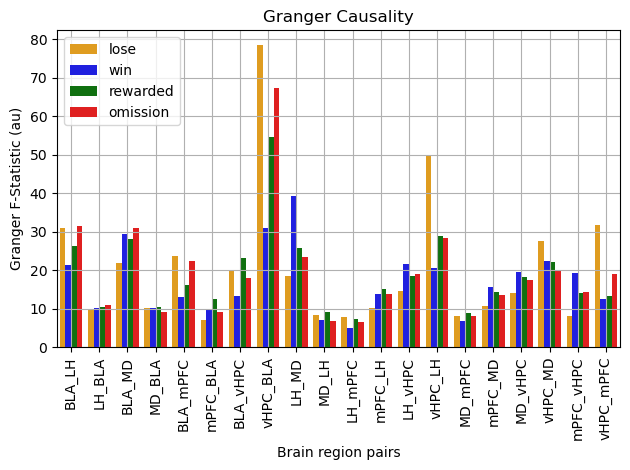

In [90]:
data=[]

for group_name, group_data in region_pair_to_outcome_to_coherence.items():
    for bar_name, bar_dict in group_data.items():
        data.append({"Group": group_name.split("trial")[0].strip("_"), "Bar": bar_name, "Granger": bar_dict["mean"], "std": bar_dict["std"]})
df = pd.DataFrame(data)
df["color"] = df["Bar"].map(BASELINE_OUTCOME_TO_COLOR)

# Create barplot
ax = sns.barplot(x='Group', y='Granger', hue='Bar', data=df, palette=df["color"], ci=None)

# Adding error bars
groups = df['Group'].unique()
bars_per_group = df['Bar'].nunique()
bar_width = 0.8 / bars_per_group
x_positions = []

for i, group in enumerate(groups):
    num_bars = df[df['Group'] == group].shape[0]
    group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
    x_positions.extend(group_positions)

plt.xticks(rotation=90)
plt.xlabel("Brain region pairs")
plt.ylabel("Granger F-Statistic (au)".format())
plt.legend(title="Trial Conditions", loc="lower left", ncol=3)
plt.title("Granger Causality")
plt.tight_layout()
plt.grid()
# plt.ylim(0,1)
plt.legend(loc="upper left")
# plt.savefig("./proc/coherence/all_zscored_lfp_power_coherence.png")
# Show the plot
plt.show()

In [36]:
raise ValueError()

ValueError: 

In [ ]:
baseline_or_trial = "baseline"
for region_1, region_2 in baseline_pairs:
    region_1_name = region_1.split("_")[0]
    region_2_name = region_2.split("_")[0]
    
    
    FULL_LFP_TRACES["{}_{}_granger".format(region_1_name, region_2_name)] = FULL_LFP_TRACES.apply(lambda row: get_granger(row, region_1, region_2), axis=1)

    FULL_LFP_TRACES["{}_{}_granger".format(region_2_name, region_1_name)] = FULL_LFP_TRACES.apply(lambda row: get_granger(row, region_2, region_1), axis=1)

    

In [ ]:
FULL_LFP_TRACES["BLA_LH_granger"].iloc[5][3][0]

In [ ]:
FULL_LFP_TRACES["LH_BLA_granger"].iloc[0][3][0]

In [ ]:
baseline_or_trial = "baseline"
for region_1, region_2 in baseline_pairs:
    region_1_name = region_1.split("_")[0]
    region_2_name = region_2.split("_")[0]

    FULL_LFP_TRACES["{}_{}_granger".format(region_1_name, region_2_name)] = FULL_LFP_TRACES.apply(lambda row: np.hstack([row[region_1][np.newaxis].T, row[region_2][np.newaxis].T]), axis=1)


    
    break
    FULL_LFP_TRACES["{}_{}_granger".format(region_1_name, region_2_name)] = FULL_LFP_TRACES.apply(lambda row: grangercausalitytests(np.hstack([row[region_1][np.newaxis].T, row[region_2][np.newaxis].T]), maxlag=[3]), axis=1)

    FULL_LFP_TRACES["{}_{}_granger".format(region_2_name, region_1_name)] = FULL_LFP_TRACES.apply(lambda row: grangercausalitytests(np.hstack([row[region_2][np.newaxis].T, row[region_1][np.newaxis].T]), maxlag=[3]), axis=1)
    break

In [ ]:
FULL_LFP_TRACES["BLA_LH_granger"].iloc[0].shape

In [ ]:
example_arr.shape

In [ ]:
example_arr = np.hstack([FULL_LFP_TRACES["BLA_trial_lfp_trace"].iloc[0][np.newaxis].T, FULL_LFP_TRACES["MD_trial_lfp_trace"].iloc[0][np.newaxis].T])

In [ ]:
example_arr = np.hstack([FULL_LFP_TRACES["MD_trial_lfp_trace"].iloc[0][np.newaxis].T, FULL_LFP_TRACES["BLA_trial_lfp_trace"].iloc[0][np.newaxis].T])

In [ ]:
grangercausalitytests(example_arr, maxlag=[3])

In [ ]:
grangercausalitytests(example_arr, maxlag=[3])

In [ ]:
region_1_name

In [ ]:
#perform Granger-Causality test
grangercausalitytests(FULL_LFP_TRACES[[baseline_pairs[0][0], baseline_pairs[0][1]]], maxlag=[3])

In [ ]:
raise ValueError()

In [ ]:
trace_columns = [col for col in channel_map_and_all_trials_df.columns if "trace" in col]

In [ ]:
trace_columns

## Power correlation between brain regions calculation

- Combining the trial/baseline and outcome label for coloring

In [ ]:
channel_map_and_all_trials_df["outcome_and_trial_or_baseline"] = channel_map_and_all_trials_df.apply(lambda x: "_".join([x["trial_outcome"], x["trial_or_baseline"]]), axis=1)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests



In [ ]:
channel_map_and_all_trials_df.columns

In [ ]:
trace_columns = [col for col in channel_map_and_all_trials_df.columns if "trace" in col]

In [ ]:
trace_columns

In [ ]:
brain_region_pairs = generate_pairs(trace_columns)

In [ ]:
brain_region_pairs

In [ ]:
grangercausalitytests(df[['column1', 'column2']], maxlag=[3])

In [ ]:
channel_map_and_all_trials_df[region_1].iloc[0]

In [ ]:
def granger

In [ ]:
for region_1, region_2 in brain_region_pairs:
    pair_base_name = "{}_{}".format(region_1.strip("trace").strip("_"), region_2.strip("trace").strip("_"))
    print(pair_base_name)
    try:
        
        # granger_value = grangercausalitytests(channel_map_and_all_trials_df[[region_1, region_2]], maxlag=[3])
        channel_map_and_all_trials_df["{}_granger".format(pair_base_name)] = channel_map_and_all_trials_df.apply(lambda row: grangercausalitytests(np.array([row[region_1], row[region_2]]).T, maxlag=[3]), axis=1)
        print()
    except Exception as e: 
        print(e)
    break

In [ ]:
channel_map_and_all_trials_df[""]

In [ ]:
channel_map_and_all_trials_df

In [ ]:
granger_value

- Filtering out the outliers

In [ ]:
band_to_power_correlation = defaultdict(dict)
for band in ALL_BANDS:
    # Getting all the pairs of brain regions
    band_averaged_columns = [col for col in channel_map_and_all_trials_df.columns if "averaged_{}".format(band) in col]
    band_to_power_correlation[band]["brain_region_pairs"] = generate_pairs(band_averaged_columns)
    print(band_to_power_correlation[band]["brain_region_pairs"])

    # Removing rows that are outliers
    filtered_df = channel_map_and_all_trials_df.copy()
    
    for col in band_averaged_columns:
        # filtered_df = filtered_df[filtered_df[col] <= 3]
        # Assuming data is a 1D numpy array
        Q1 = np.percentile(filtered_df[col], 25)
        Q3 = np.percentile(filtered_df[col], 75)
        IQR = Q3 - Q1
        band_to_power_correlation[band]["outlier_removed_df"] = filtered_df[(filtered_df[col] >= Q1 - 1.5 * IQR) & (filtered_df[col] <= Q3 + 1.5 * IQR)]


    
    # Getting the mean and standard deviation
    

In [ ]:
band_to_power_correlation = defaultdict(dict)
for band in ALL_BANDS:
    # Getting all the pairs of brain regions
    band_averaged_columns = [col for col in channel_map_and_all_trials_df.columns if "averaged_{}".format(band) in col]
    band_to_power_correlation[band]["brain_region_pairs"] = generate_pairs(band_averaged_columns)
    print(band_to_power_correlation[band]["brain_region_pairs"])

    # Removing rows that are outliers
    filtered_df = channel_map_and_all_trials_df.copy()
    
    for col in band_averaged_columns:
        # filtered_df = filtered_df[filtered_df[col] <= 3]
        # Assuming data is a 1D numpy array
        Q1 = np.percentile(filtered_df[col], 25)
        Q3 = np.percentile(filtered_df[col], 75)
        IQR = Q3 - Q1
        filtered_df = filtered_df[(filtered_df[col] >= Q1 - 1.5 * IQR) & (filtered_df[col] <= Q3 + 1.5 * IQR)]
    band_to_power_correlation[band]["outlier_removed_df"] = filtered_df

In [ ]:
channel_map_and_all_trials_df.shape

In [ ]:
band_to_power_correlation[band]["outlier_removed_df"].shape

- Plotting all of the conditions

In [ ]:
for band in ALL_BANDS:
    for region_1, region_2 in band_to_power_correlation[band]["brain_region_pairs"]:
        region_1_basename = region_1.split("_")[0]
        region_2_basename = region_2.split("_")[0]
        x = band_to_power_correlation[band]["outlier_removed_df"][region_1]
        y = band_to_power_correlation[band]["outlier_removed_df"][region_2]
        
        # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        
        # Create a line of best fit using the slope and intercept
        line = slope * x + intercept
        
        # Create scatter plot
        sns.scatterplot(x=x, y=y, data=band_to_power_correlation[band]["outlier_removed_df"], hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR)
        
        # Plot line of best fit
        plt.plot(x, line, color='red')
        
        # Add R² value to the plot
        plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
        
        # Add labels and legend
        plt.title("Power correlation of Z-scored {} band LFP: {} and {}".format(band, region_2_basename, region_1_basename))
        plt.xlabel('{} {} power of Z-scored LFP'.format(band, region_1_basename))
        plt.ylabel('{} {} power of Z-scored LFP'.format(band, region_2_basename))
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig("./proc/power_correlation/zscored/{}/all_condition_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(band, region_1_basename, region_2_basename, band))
        # Display the plot
        plt.show()




In [ ]:
raise ValueError()

In [ ]:
channel_map_and_all_trials_df = filtered_df

In [ ]:
channel_map_and_all_trials_df["trial_outcome"].unique()

In [ ]:
channel_map_and_all_trials_df["trial_or_baseline"]

In [ ]:
for band in ALL_BANDS:
    band_df = band_to_power_correlation[band]["outlier_removed_df"]
    band_to_power_correlation[band]["region_pair_to_outcome_to_r2"] = defaultdict(nested_dict)
    for outcome in band_df["trial_outcome"].unique():
        outcome_df = band_df[band_df["trial_outcome"] == outcome]
        for region_1, region_2 in brain_region_pairs:
            region_1_basename = region_1.split("_")[0]
            region_2_basename = region_2.split("_")[0]
            
            x = outcome_df[region_1]
            y = outcome_df[region_2]
            
            # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            # Square the r value to get the r squared value
            r2_value = r_value**2
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["r"] = r_value
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["std"] = std_err
            
            # Create a line of best fit using the slope and intercept
            line = slope * x + intercept
            
            # Create scatter plot
            sns.scatterplot(x=x, y=y, data=outcome_df, hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR, style='outcome_and_trial_or_baseline', markers=['^', 'o'])
            
            # Plot line of best fit
            plt.plot(x, line, color='red')
            
            # Add R² value to the plot
            plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
            
            # Add labels and legend
            plt.title("Power Correlation of Z-scored {} LFP: {} and {}".format(band, region_2_basename, region_1_basename))
            plt.xlabel('{} {} Power of Z-scored LFP'.format(region_1_basename, band))
            plt.ylabel('{} {} Power of Z-scored LFP'.format(region_2_basename, band))
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.savefig("./proc/power_correlation/zscored/{}/{}_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(band, outcome, region_1_basename, region_2_basename, band))
            # Display the plot
            plt.show()

In [ ]:
for band in ALL_BANDS:
    # Convert the nested dictionary to a DataFrame
    data = []
    for group_name, group_data in band_to_power_correlation[band]['region_pair_to_outcome_to_r2'].items():
        for bar_name, bar_dict in group_data.items():
            data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
    df = pd.DataFrame(data)
    
    # Create the bar plot using seaborn
    # sns.catplot(
    #     data=df, 
    #     x='Group', 
    #     y='r2', 
    #     hue='Bar', 
    #     kind='bar', 
    #     height=4, 
    #     aspect=2,
    #     legend=False,
    #     # yerr=df['std'].values,  # This line adds the SEM bars
    #     # capsize=0.1  # This line adds caps on the error bars
    # )
    
    # Create barplot
    ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None)
    
    # Adding error bars
    groups = df['Group'].unique()
    bars_per_group = df['Bar'].nunique()
    bar_width = 0.8 / bars_per_group
    x_positions = []
    
    for i, group in enumerate(groups):
        num_bars = df[df['Group'] == group].shape[0]
        group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
        x_positions.extend(group_positions)
    
    for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
        plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)
    
    
    plt.xticks(rotation=90)
    plt.xlabel("Brain region pairs")
    plt.ylabel("Power correlation r")
    plt.legend(title="Trial Conditions")
    plt.title("{} Power correlations".format(band))
    plt.tight_layout()
    plt.grid()
    
    plt.savefig("./proc/power_correlation/zscored/all_zscored_{}_lfp_power_correlation.png".format(band))
    # Show the plot
    plt.show()

In [ ]:

# Convert the nested dictionary to a DataFrame
data = []
for group_name, group_data in region_pair_to_outcome_to_r2.items():
    for bar_name, bar_dict in group_data.items():
        data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
df = pd.DataFrame(data)

# Create the bar plot using seaborn
# sns.catplot(
#     data=df, 
#     x='Group', 
#     y='r2', 
#     hue='Bar', 
#     kind='bar', 
#     height=4, 
#     aspect=2,
#     legend=False,
#     # yerr=df['std'].values,  # This line adds the SEM bars
#     # capsize=0.1  # This line adds caps on the error bars
# )

# Create barplot
ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None)

# Adding error bars
groups = df['Group'].unique()
bars_per_group = df['Bar'].nunique()
bar_width = 0.8 / bars_per_group
x_positions = []

for i, group in enumerate(groups):
    num_bars = df[df['Group'] == group].shape[0]
    group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
    x_positions.extend(group_positions)

for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
    plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)


plt.xticks(rotation=90)
plt.xlabel("Brain region pairs")
plt.ylabel("Power correlation r")
plt.legend(title="Trial Conditions")
plt.title("Power correlations")
plt.tight_layout()
plt.grid()

plt.savefig("./proc/power_correlation/zscored/all_zscored_lfp_power_correlation.png")
# Show the plot
plt.show()